ChromaDB를 'C:\Users\mojih\OneDrive\바탕 화면\Project4\SKN13-4th-4Team\crawling\chroma' 경로에서 불러오는 중...
ChromaDB 불러오기 성공.
로드된 컬렉션 'rehabilitation_articles_openai'에 총 73792개의 문서가 있습니다.

--- 문서 검색 테스트 시작 ---
질문: '재활 운동이 무릎 통증에 어떤 영향을 미치나요?'

'재활 운동이 무릎 통증에 어떤 영향을 미치나요?'에 대한 검색 결과 (3개 문서):

--- 문서 1 ---
소스 (메타데이터): Hip, Knee, and Ankle Osteoarthritis Negatively Affects Mechanical Energy Exchange.
내용 (일부): Individuals with osteoarthritis (OA) of the lower limb find normal locomotion tiring compared with individuals without OA, possibly because OA of any lower limb joint changes limb mechanics and may disrupt transfer of potential and kinetic energy of the center of mass during walking, resulting in increased locomotor costs. Although recovery has been explored in asymptomatic individuals and in some patient populations, the effect of changes in these gait parameters on center of mass movements and...
------------------------------

--- 문서 2 ---
소스 (메타데이터): Does the addition of hip strengthening 

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


--- RAGAS 최종 평가 결과 ---
{'faithfulness': 1.0000, 'answer_relevancy': 0.1492, 'context_relevancy': 0.1038, 'answer_correctness': 0.2142}

--- RAGAS 지표 설명 ---
- Faithfulness (충실도): 생성된 답변이 검색된 문서에 얼마나 근거하는가? (환각 방지)
- Answer Relevancy (답변 관련성): 생성된 답변이 원래 질문에 얼마나 관련성이 높은가?
- Context Relevancy (문맥 관련성): 검색된 문서가 질문에 얼마나 관련성이 높은가?
- Answer Correctness (답변 정확성): 생성된 답변이 'ground_truth_answer'에 얼마나 가까운가?

각 지표는 0에서 1 사이의 값으로, 1에 가까울수록 좋습니다.

--- RAGAS 평가 결과 시각화 ---


C:\Users\mojih\AppData\Local\Temp\ipykernel_18664\1203515632.py:228: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_scores.index, y=avg_scores.values, palette='viridis')


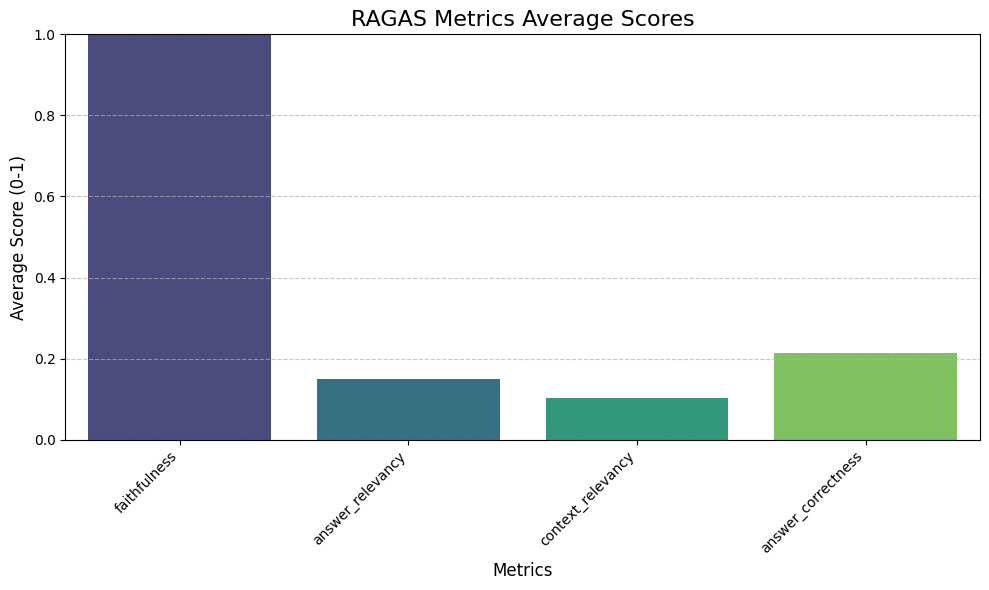

In [ ]:
import os
from langchain_community.vectorstores import Chroma # langchain_community로 변경될 수 있음
from langchain_openai import OpenAIEmbeddings, ChatOpenAI # langchain_openai로 변경될 수 있음
from langchain.tools.retriever import create_retriever_tool
from langchain.chains import RetrievalQA # RAG 체인 생성을 위해 추가
from dotenv import load_dotenv
from datasets import Dataset # ragas 평가를 위한 Dataset 클래스
from ragas import evaluate # ragas 평가 함수
from ragas.metrics import ( # ragas에서 제공하는 평가 지표들
    faithfulness,
    answer_relevancy,
    context_relevancy, # 이 부분에서 ImportError가 발생할 경우, ragas 라이브러리를 최신 버전으로 업데이트하세요: pip install --upgrade ragas 또는 pip install ragas --no-cache-dir --force-reinstall
    answer_correctness, # 이 지표는 ground_truth_answer가 필요
    context_recall # 이 지표는 ground_truths (검색되어야 할 문서)가 필요하지만, 여기서는 생략
)
import warnings

# --- 시각화를 위한 라이브러리 추가 ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DeprecationWarning 무시 설정 (LangChain 버전업으로 인한 경고 처리)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 환경 변수 로드 (OPENAI_API_KEY를 위해)
load_dotenv()

# --- ChromaDB 설정 ---
# 병합된 ChromaDB 파일(chroma.sqlite3)이 들어있는 디렉토리 경로를 정확히 지정하세요.
# 예시: r"C:\Users\mojih\OneDrive\바탕 화면\Project4\SKN13-4th-4Team\ai_influencer_agent\merged_rehabilitation_chroma_data"
# 이 경로를 당신의 실제 경로로 수정해야 합니다!
# SyntaxError 해결: raw f-string (rf"...") 사용 또는 슬래시(/) 사용
PERSIST_DIRECTORY = rf"C:\Users\mojih\OneDrive\바탕 화면\Project4\SKN13-4th-4Team\crawling\chroma"

# ChromaDB 컬렉션 이름 (이전에 데이터를 저장했던 컬렉션 이름과 동일해야 합니다)
COLLECTION_NAME = "rehabilitation_articles_openai"

# OpenAI 임베딩 모델 초기화 (DB 생성 시 사용한 모델과 동일해야 합니다)
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-large")

# 저장된 Chroma 벡터 DB 불러오기
print(f"ChromaDB를 '{PERSIST_DIRECTORY}' 경로에서 불러오는 중...")
try:
    vectordb = Chroma(
        persist_directory=PERSIST_DIRECTORY,
        embedding_function=embeddings_model,
        collection_name=COLLECTION_NAME # 명시적으로 컬렉션 이름을 지정하여 올바른 컬렉션을 로드
    )
    print("ChromaDB 불러오기 성공.")
except Exception as e:
    print(f"ChromaDB 불러오기 오류: {e}")
    print("경로가 올바른지, 또는 해당 디렉토리 안에 'chroma.sqlite3' 파일이 있는지 확인해주세요.")
    exit()

# 컬렉션에 문서가 몇 개 있는지 확인
try:
    doc_count = vectordb._collection.count()
    print(f"로드된 컬렉션 '{COLLECTION_NAME}'에 총 {doc_count}개의 문서가 있습니다.")
    if doc_count == 0:
        print("❗ 경고: 컬렉션에 문서가 없습니다. 병합이 제대로 되었는지 확인해주세요.")
except Exception as e:
    print(f"컬렉션 문서 수 확인 중 오류 발생: {e}")


# 관련 문서 최대 3개 검색하는 retriever 생성
retriever = vectordb.as_retriever(search_kwargs={"k": 3})

# --- Tool 생성 (선택 사항, RAG 에이전트에서 사용) ---
q_a_tool = create_retriever_tool(
    retriever,
    name="q_a_tool",
    description="사용자의 의학 관련 궁금증에 대해 쉽게 설명하는 도구입니다."
)

# --- 문서 검색 테스트 ---
print("\n--- 문서 검색 테스트 시작 ---")

# 임의의 질문을 입력하여 테스트합니다.
# 당신이 수집한 논문 내용과 관련된 질문일수록 더 좋은 결과를 얻을 수 있습니다.
test_query = "재활 운동이 무릎 통증에 어떤 영향을 미치나요?"
# test_query = "필라테스의 효과는 무엇인가요?"
# test_query = "생체역학 연구의 최신 동향은?"

print(f"질문: '{test_query}'")

try:
    # retriever를 사용하여 관련 문서 검색 (deprecated 경고 해결을 위해 invoke 사용)
    relevant_documents = retriever.invoke(test_query) # get_relevant_documents 대신 invoke 사용

    if relevant_documents:
        print(f"\n'{test_query}'에 대한 검색 결과 ({len(relevant_documents)}개 문서):")
        for i, doc in enumerate(relevant_documents):
            print(f"\n--- 문서 {i+1} ---")
            print(f"소스 (메타데이터): {doc.metadata.get('title', '제목 없음')}") # 메타데이터에서 'title' 사용
            print(f"내용 (일부): {doc.page_content[:500]}...") # 문서 내용의 앞부분 출력
            print("-" * 30)
    else:
        print("관련 문서를 찾을 수 없습니다.")
        print("팁: 질문을 좀 더 일반적이거나, 수집된 논문의 키워드와 유사하게 변경해 보세요.")

except Exception as e:
    print(f"문서 검색 중 오류 발생: {e}")
    print("OpenAI API 키가 유효한지, 또는 임베딩 모델 설정이 올바른지 확인해주세요.")

print("\n--- 문서 검색 테스트 완료 ---")


# --- RAGAS 평가를 위한 LLM 설정 ---
# ragas는 평가를 위해 내부적으로 LLM을 사용합니다.
# 여기서는 ChatOpenAI를 사용합니다.
# model_name은 평가의 정확도에 영향을 미치므로 적절한 모델을 선택하세요 (예: "gpt-4", "gpt-3.5-turbo").
# temperature는 0으로 설정하여 일관된 평가 결과를 얻는 것이 좋습니다.
llm_for_ragas_eval = ChatOpenAI(model_name="gpt-4.1-mini", temperature=0)

# --- RAG 체인 설정 (질문 + 검색된 문서 -> 답변 생성) ---
# RetrievalQA 체인을 사용하여 LLM이 검색된 문서를 바탕으로 답변을 생성하도록 합니다.
qa_chain = RetrievalQA.from_chain_type(
    llm=llm_for_ragas_eval,
    chain_type="stuff", # 검색된 모든 문서를 하나의 프롬프트에 넣는 방식
    retriever=retriever,
    return_source_documents=True # 원본 문서를 반환하도록 설정 (ragas contexts 필드에 필요)
)

# --- RAGAS 평가 데이터셋 준비 ---
# ragas 평가는 Dataset 객체를 필요로 합니다.
# 각 질문에 대해 'question', 'answer', 'contexts', 'ground_truth_answer' 필드가 필요합니다.
# 'ground_truth_answer'는 수동으로 작성해야 합니다.

print("\n--- RAGAS 평가 데이터셋 준비 중 ---")

# 여기에 평가하고 싶은 질문과 그에 대한 '정답'을 추가하세요.
# 'ground_truth_answer'는 매우 중요하며, LLM이 생성한 답변과 별개로 사람이 작성한 '참고 답변'입니다.
eval_examples = [
    {
        "question": "재활 운동이 무릎 통증에 어떤 영향을 미치나요?",
        "ground_truth_answer": "재활 운동은 무릎 통증 감소, 관절 기능 향상, 근력 강화 및 안정성 증대에 긍정적인 영향을 미칩니다. 이는 통증의 원인이 되는 염증을 줄이고, 약해진 근육을 강화하여 무릎 관절에 가해지는 부담을 경감시키기 때문입니다."
    },
    {
        "question": "필라테스의 주요 효과는 무엇인가요?",
        "ground_truth_answer": "필라테스는 코어 근육 강화, 자세 교정, 유연성 및 균형 감각 향상, 스트레스 감소, 신체 인지 능력 증진 등의 효과가 있습니다. 특히 복부, 등, 엉덩이 근육을 중심으로 전신 근육을 강화하여 신체 정렬을 돕습니다."
    },
    {
        "question": "생체역학 연구의 최신 동향은 무엇인가요?",
        "ground_truth_answer": "생체역학 연구는 웨어러블 센서, AI 기반 동작 분석, 3D 프린팅을 활용한 맞춤형 보조기구 개발, 가상 현실(VR) 및 증강 현실(AR)을 이용한 재활 훈련 등 다양한 최신 동향을 보이고 있습니다. 이는 데이터 기반의 정밀한 인체 움직임 분석과 개인 맞춤형 치료법 개발에 기여합니다."
    }
]

# ragas 평가를 위한 데이터 리스트
ragas_data = []

for example in eval_examples:
    question = example["question"]
    # ground_truth_answer 대신 'ground_truth' 키를 사용하도록 수정
    ground_truth = example["ground_truth_answer"] 

    print(f"\n질문: '{question}'에 대한 답변 생성 및 데이터 수집 중...")
    
    # RAG 체인을 통해 답변 생성 및 검색된 문서 가져오기
    # invoke 대신 chain.run() 또는 chain.invoke()를 사용할 수 있습니다.
    # 여기서는 invoke를 사용하여 더 명확하게 입력/출력 구조를 따릅니다.
    try:
        result = qa_chain.invoke({"query": question})
        generated_answer = result["result"] # LLM이 생성한 최종 답변
        # 검색된 문서의 page_content만 추출하여 contexts 리스트로 만듭니다.
        contexts = [doc.page_content for doc in result["source_documents"]]
        
        ragas_data.append({
            "question": question,
            "answer": generated_answer,
            "contexts": contexts,
            "ground_truth": ground_truth # 'ground_truth_answer' 대신 'ground_truth' 사용
        })
        print(f"  > 생성된 답변: {generated_answer[:100]}...")
        print(f"  > 검색된 문서 수: {len(contexts)}개")

    except Exception as e:
        print(f"  > 답변 생성 중 오류 발생: {e}")
        print(f"  > 이 질문은 평가 데이터셋에서 제외됩니다.")
        continue

# 리스트를 Dataset 객체로 변환
eval_dataset = Dataset.from_list(ragas_data)

print("\n--- RAGAS 평가 시작 ---")

# ragas 평가 지표 정의
# context_recall은 ground_truths (검색되어야 할 이상적인 문서) 필드가 필요하므로 여기서는 제외합니다.
# 만약 ground_truths를 수동으로 정의할 수 있다면 포함할 수 있습니다.
metrics = [
    faithfulness,
    answer_relevancy,
    context_relevancy,
    answer_correctness,
]

# ragas 평가 실행
# 이 과정에서 LLM_for_ragas_eval이 내부적으로 사용되어 평가를 수행합니다.
try:
    ragas_results = evaluate(
        dataset=eval_dataset, 
        metrics=metrics, 
        llm=llm_for_ragas_eval, # 평가에 사용할 LLM 지정
        embeddings=embeddings_model # 임베딩 모델 지정 (context_relevancy 등에서 사용)
    )

    # 평가 결과 출력
    print("\n--- RAGAS 최종 평가 결과 ---")
    print(ragas_results)
    print("\n--- RAGAS 지표 설명 ---")
    print("- Faithfulness (충실도): 생성된 답변이 검색된 문서에 얼마나 근거하는가? (환각 방지)")
    print("- Answer Relevancy (답변 관련성): 생성된 답변이 원래 질문에 얼마나 관련성이 높은가?")
    print("- Context Relevancy (문맥 관련성): 검색된 문서가 질문에 얼마나 관련성이 높은가?")
    print("- Answer Correctness (답변 정확성): 생성된 답변이 'ground_truth_answer'에 얼마나 가까운가?")
    print("\n각 지표는 0에서 1 사이의 값으로, 1에 가까울수록 좋습니다.")

    # --- RAGAS 평가 결과 시각화 (pandas, matplotlib, seaborn 사용) ---
    print("\n--- RAGAS 평가 결과 시각화 ---")

    # 평가 결과를 pandas DataFrame으로 변환
    df_results = ragas_results.to_pandas()

    # 각 지표의 평균 점수 계산
    avg_scores = df_results[['faithfulness', 'answer_relevancy', 'context_relevancy', 'answer_correctness']].mean()

    # 시각화 설정
    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_scores.index, y=avg_scores.values, palette='viridis')
    plt.title('RAGAS Metrics Average Scores', fontsize=16)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Average Score (0-1)', fontsize=12)
    plt.ylim(0, 1) # 점수 범위는 0에서 1 사이
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right') # x축 레이블 회전
    plt.tight_layout() # 레이아웃 자동 조정
    plt.show() # 그래프 표시

except Exception as e:
    print(f"\nRAGAS 평가 중 오류 발생: {e}")
    print("OpenAI API 키가 유효한지, 또는 인터넷 연결이 잘 되어 있는지 확인해주세요.")
    print("ragas 문서: https://docs.ragas.io/en/latest/")


In [7]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import chromadb
import os

#ChromaDB 데이터가 저장된 절대 경로 지정
#Windows 경로이므로 역슬래시() 대신 슬래시(/)를 사용하거나, 이중 역슬래시(\)를 사용해야 합니다.
db_path = "C:\Users\mojih\OneDrive\바탕 화면\Project4\SKN13-4th-4Team\crawling\chroma"
#또는 db_path = "C:\Documents\chroma_pubmed_abstract_only"
#ChromaDB 클라이언트 초기화
#지정된 경로에 ChromaDB 데이터가 없으면 새로 생성됩니다.
#기존 데이터가 있다면 해당 데이터를 로드합니다.
client = chromadb.PersistentClient(path=db_path)

#모든 컬렉션 목록 가져오기
collections = client.list_collections()

if collections:
    print(f"'{db_path}' 경로에 있는 ChromaDB 컬렉션 목록:")
    for collection in collections:
        print(f"- 컬렉션 이름: {collection.name}")

#각 컬렉션에 적재된 문서(임베딩) 개수 확인
        num_documents = collection.count()
        print(f"  > 적재된 문서(임베딩) 개수: {num_documents}개")

        # (선택 사항) 컬렉션의 첫 5개 문서 ID와 메타데이터 출력
        # try:
        #     results = collection.get(limit=5)
        #     print("  > 첫 5개 문서 ID와 메타데이터:")
        #     for i, doc_id in enumerate(results['ids']):
        #         print(f"    - ID: {doc_id}, Metadata: {results['metadatas'][i]}")
        # except Exception as e:
        #     print(f"  > 문서 정보를 가져오는 중 오류 발생: {e}")

else:
    print(f"'{db_path}' 경로에 ChromaDB 컬렉션이 없습니다.")